In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import copy
import colorspacious as cs

In [2]:
measurments = pd.read_csv("data/LabMeasurements-Color-Card.csv", decimal=',', sep=';')
master_colors = pd.read_csv("data/MasterColorCard.csv", decimal=',', sep=';')

# make multilevel index for measurments columns
row = measurments['Row']
col = measurments['Column']
measurments = measurments.drop(['Row', 'Column'], axis=1)
new_cols = pd.MultiIndex.from_tuples(
    [(int(col[1:]), col[0]) for col in measurments.columns]
)
measurments.columns = new_cols
measurments.insert(0, 'Row', row)
measurments.insert(1, 'Column', col)

# make multilevel index for master color rows
master_colors.set_index(['Crow', 'Ccol'], inplace=True)

- 13 color sheets
- each sheet has 42 color cards (7x6)
- each color card has 64 (8x8) color spots

In [32]:
# compute errors
errors = copy(measurments)
for row in range(1,9):
    for col in range(1,9):
        spot = row*10+col

        master_L = master_colors.loc[row, col]['L']
        master_a = master_colors.loc[row, col]['a']
        master_b = master_colors.loc[row, col]['b']

        errors.loc[:, (spot, 'L')] = errors.loc[:, (spot, 'L')] - master_L
        errors.loc[:, (spot, 'a')] = errors.loc[:, (spot, 'a')] - master_a
        errors.loc[:, (spot, 'b')] = errors.loc[:, (spot, 'b')] - master_b

In [67]:
master_colors.head()

Field  p1  p2  p3  p4  p5       L       a       b
Crow Ccol                                                   
1    1         1   0   0   0  61   0  51.641   0.169   3.054
     2         2  39   0  73  60   0  43.875 -12.593  22.126
     3         3   0   0   0  61   0  51.641   0.169   3.054
     4         4  57  29   0  31   0  49.728  -3.525 -22.457
     5         5  46  38   0   7   0  56.471   9.119 -24.736

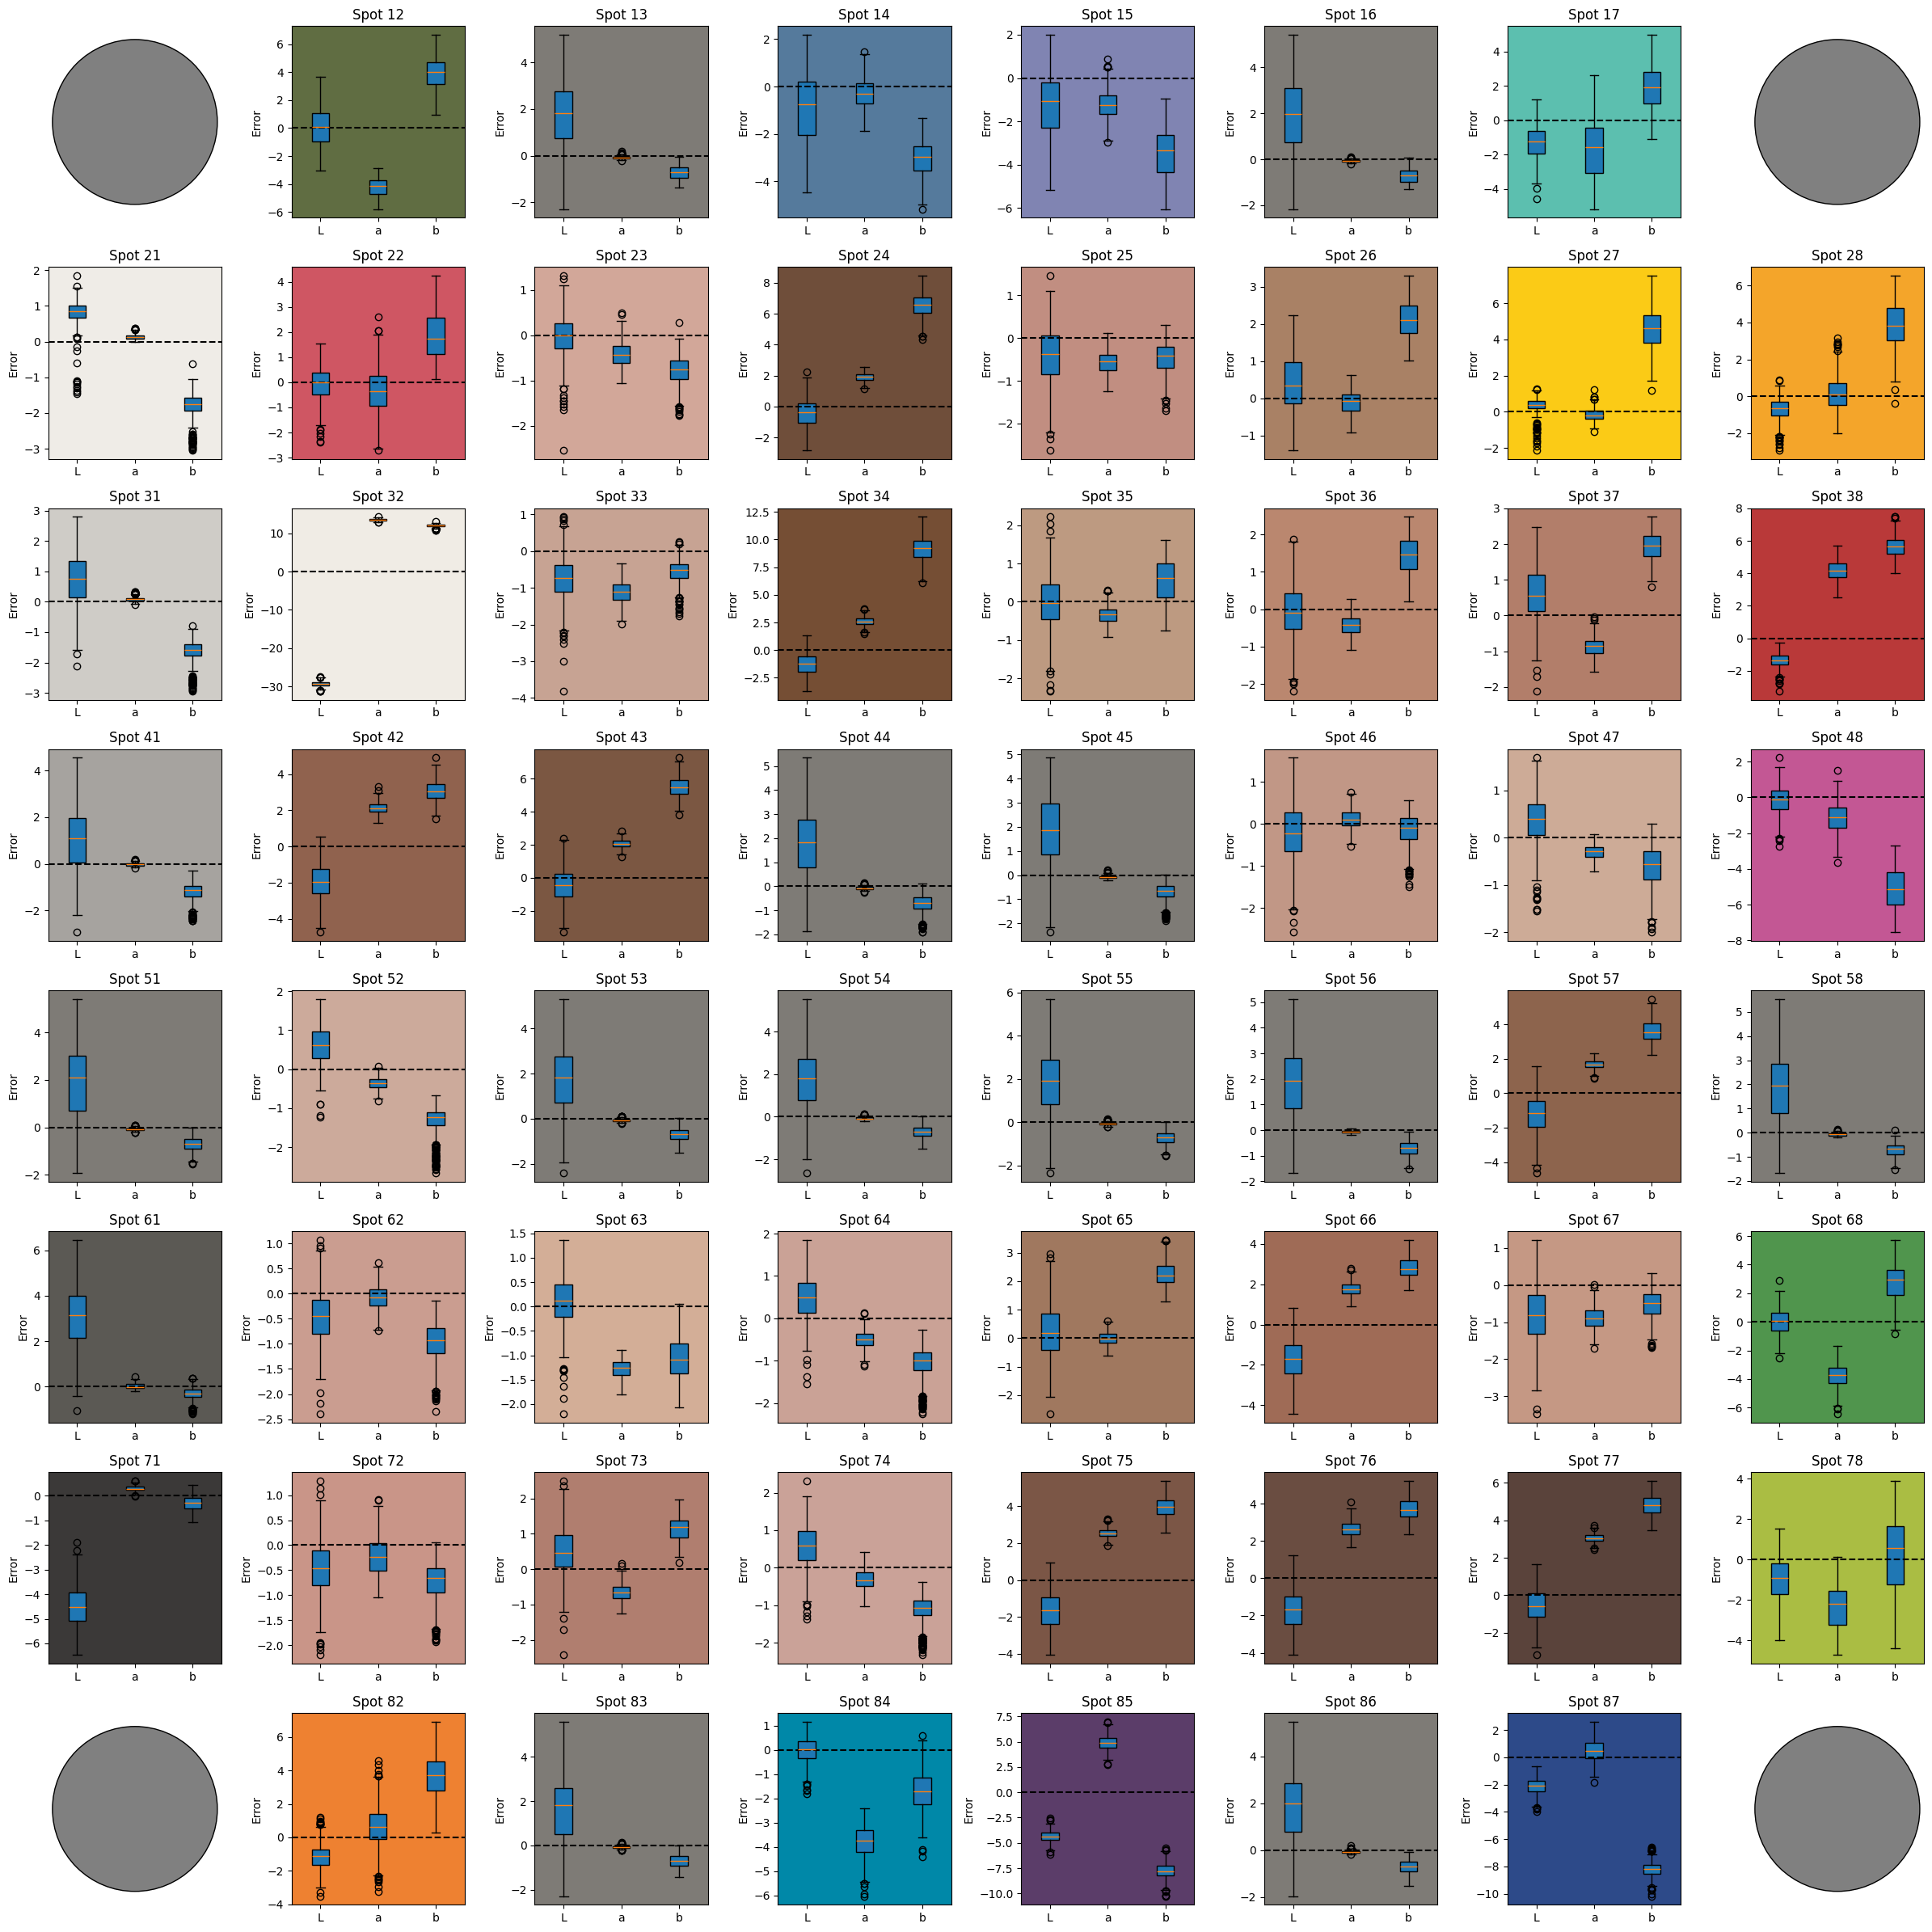

In [88]:
fig, axes = plt.subplots(8,8, figsize=(24,24))

# TODO: use distinct colors for boxplots, they sometimes blend into the background

for row in range(1,9):
    for col in range(1,9):
        ax = axes[row-1, col-1]
        spot = row*10+col

        if spot in [11, 18, 81, 88]:
            circle = patches.Circle((0.0, 0.0), 10, facecolor='gray', edgecolor='black')
            ax.add_patch(circle)
            ax.set_aspect('equal')
            ax.set_xlim([-10.5,10.5])
            ax.set_ylim([-10.5,10.5])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        L = errors[spot]['L'].values
        a = errors[spot]['a'].values
        b = errors[spot]['b'].values

        L_master = master_colors.loc[row, col]['L']
        a_master = master_colors.loc[row, col]['a']
        b_master = master_colors.loc[row, col]['b']
        master_color = cs.cspace_convert([L_master, a_master, b_master], "CIELab", "sRGB1")
        master_color = np.clip(master_color, 0, 1)

        bplt = ax.boxplot([L,a,b], patch_artist=True)

        # format plot
        ax.set_facecolor(master_color)
        ax.axhline(0, color='black', linestyle='--')
        ax.set_xticks([1,2,3], ['L', 'a', 'b'])
        ax.set_ylabel('Error')
        ax.set_title(f"Spot {spot}")
        #ax.set_ylim([-11, 11])

plt.tight_layout()
plt.savefig("figures/boxplots.png")